## IMPORT MODULES AND DATA PROCESSING

In [6]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import warnings
import numpy as np
import torch
import random
import os
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from pathlib import Path
from data_processing.read_data import generate_MAPAL_data,generate_new_data
from annotator.Model import Annotator
from classifier.Model import LR,PWC
from classifier.trainer import train_LR
from classifier.evaluation import eval_model,classf_eval_after_warmup,classf_eval_after_training, compare_true_label,print_scores,classifier_Val_scores_during_AL
from classifier.warmup import warmedup_classifiers
from annotator.warmup import annotator_warmup
from annotator.evaluation import eval_annotator_model,annot_eval_after_warmup, annot_eval_after_training,annotator_AL_loss
from AL_design.train_scheme import AL_train_cycle,AL_train_cycle_KB,AL_train_majority,AL_train_MAPAL_instances
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from stats.utils import diverse_samples
from sklearn.metrics.pairwise import cosine_similarity,euclidean_distances
from sklearn.metrics import accuracy_score, f1_score
from knowledge_base.utils import Knowledge_Base_Metrics

if torch.cuda.is_available(): 
 device = "cuda:0" 
else: 
 device = "cpu" 


def set_seed(seed: int = 42) -> None:  
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    print(f"Random seed set as {seed}")


Dataset = "iris-simulated-x"

Data_folder_path = "datasets"

Data_path = Data_folder_path + "/" + Dataset + ".csv"


budget_frac = 0.2
test_ratio = 0.4
boot_size = 0.05
s_t = 0.95 # SIMILARITY THRESHOLD --- 1 (check)
w_t = 0.7 # WEIGHT THRESHOLD ---- 1 (check)

seed = 1
set_seed(seed)


parent_dir_1 = "results/Knowledge_Base/"
dir_name_1 = Dataset + "-"+str(budget_frac) + "-" + str(s_t) + "-" + str(w_t)

Path_results = os.path.join(parent_dir_1,dir_name_1)
if not os.path.isdir(Path_results):
    os.mkdir(Path_results)
print("Knowledge Base Results directory path : ",Path_results)

parent_dir_2 = "data_processing"
dir_name_2 = Dataset + "-" + str(budget_frac)
Path_mapal_data = os.path.join(parent_dir_2,dir_name_2)
if not os.path.isdir(Path_mapal_data):
    os.mkdir(Path_mapal_data)
print("MAPAL executed data directory path : ",Path_mapal_data)

#specify path for export text file
txt_path = Path_results +"/comparison.txt"

with open(txt_path, 'a') as f:
    f.write(Dataset+"\n")
    f.write("Budget : "+str(budget_frac)+"\n")
    f.write("Similarity Threshold : "+str(s_t)+"\n")
    f.write("Weight Threshold : "+str(w_t)+"\n")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Random seed set as 1
Knowledge Base Results directory path :  results/Knowledge_Base/iris-simulated-x-0.2-0.95-0.7
MAPAL executed data directory path :  data_processing\iris-simulated-x-0.2


In [7]:
# RUN CELL TO GENERATE FRESH DATA

TRAIN, VAL, BOOT, ACTIVE, budget = generate_new_data(Data_path,budget = budget_frac,test_ratio=test_ratio,boot_size = boot_size, seed = seed)
x_train, y_train, y_annot_train = TRAIN
x_val, y_val, y_annot_val = VAL
x_boot, y_boot, y_annot_boot = BOOT
x_active, y_active, y_annot_active = ACTIVE
m = y_annot_active.shape[1]

MAPAL budget :  90
Our Budget :  70


In [ ]:
## RUN MAPAL
! python src/evaluation_scripts/experimental_setup.py \
  --query_strategy  mapal-1-0.0001-2-1-entropy\
  --data_set seeds-simulated-x \
  --dir_name seeds-simulated-x-0.4\
  --results_path results/simulated-x\
  --test_ratio 0.4 \
  --budget 0.4 \
  --seed 1

In [ ]:
# ## RUN MAPAL
# ! python3 src/evaluation_scripts/experimental_setup.py \
#   --query_strategy mapal-1-0.0001-2-1-entropy \
#   --data_set ionosphere-simulated-x \
#   --dir_name ionosphere-simulated-x-0.4\
#   --results_path results/reports-mozilla\
#   --test_ratio 0.4 \
#   --budget 0.4 \
#   --seed 1

In [8]:
## RUN CELL TO USE MAPAL GENERATED DATA

TRAIN, VAL, BOOT, ACTIVE, instance_annotator_pair, Mapal_Data, ordered_instances, budget, MAPAL_results_path = generate_MAPAL_data(Path_mapal_data,boot_size,seed)
x_train, y_train, y_annot_train = TRAIN
x_val, y_val, y_annot_val = VAL
x_boot, y_boot, y_annot_boot = BOOT
x_active, y_active, y_annot_active = ACTIVE
m = y_annot_active.shape[1]
new_x_train,new_y_train,new_y_annot_train = Mapal_Data
Mapal_Data_Frame = pd.read_csv(MAPAL_results_path)
Mapal_Data_Frame

MAPAL budget :  90
Our Budget :  70


,index,train-micro-misclf-rate,test-micro-misclf-rate,train-macro-misclf-rate,test-macro-misclf-rate,n-labeled-samples,n-true-labels-0,n-false-labels-0,n-true-labels-1,n-false-labels-1,n-true-labels-2,n-false-labels-2,n-true-labels-3,n-false-labels-3,n-true-labels-4,n-false-labels-4,n-true-labels,n-false-labels,times
0,0,0.677778,0.633333,0.643406,0.665205,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000
1,1,0.677778,0.650000,0.666667,0.666667,1,0,0,0,0,0,0,0,1,0,0,0,1,0.013699
2,2,0.677778,0.650000,0.666667,0.666667,2,1,0,0,0,0,0,0,1,0,0,1,1,0.013403
3,3,0.677778,0.650000,0.666667,0.666667,3,1,0,0,1,0,0,0,1,0,0,1,2,0.013922
4,4,0.677778,0.650000,0.666667,0.666667,4,1,0,0,1,0,0,0,1,1,0,2,2,0.012765
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,86,0.266667,0.316667,0.262081,0.327444,50,4,12,9,6,7,7,15,9,12,5,47,39,0.020559
87,87,0.277778,0.383333,0.275108,0.390936,50,4,12,9,6,7,7,15,9,12,6,47,40,0.040046
88,88,0.266667,0.316667,0.262464,0.327444,50,4,12,10,6,7,7,15,9,12,6,48,40,0.010492
89,89,0.244444,0.316667,0.240242,0.327444,51,4,12,11,6,7,7,15,9,12,6,49,40,0.010905


In [9]:
labels, frequency = np.unique(y_val,return_counts=True)
print('Labels : ',labels)
print('Frequency : ',frequency)
num_class = len(labels)
f1_average = None
if num_class >2:
    f1_average = 'macro'

Mapal_Data_Frame_len = Mapal_Data_Frame.shape[0]
Mapal_Data_accuracy = 1 - Mapal_Data_Frame['test-micro-misclf-rate'].loc[Mapal_Data_Frame_len-1]
Mapal_Data_accuracy

#export DataFrame to text file
with open(txt_path, 'a') as f:
    f.write("\n\nNumber of classes : "+str(num_class)+"\n\n\n")
    f.write("MAPAL Accuracy : "+str(Mapal_Data_accuracy))

Labels :  [0 1 2]
Frequency :  [19 21 20]


In [5]:
data_c_AM = [{},{},{},{}] ## Store Classifier Metrics corresponsind to classifier trained on Annotator Model Labels
data_c_KB = [{},{},{},{}]  ## Store Clasifier Metrics corresponding to classifier traned with Knowledge Base
data_c_WO = [{},{},{},{}] ## Store Classifier Metrics corresponsind to classifier trained on W Optimal Labels
data_c_AM_EE = [{},{},{},{}] ## Store Classifier Metrics corresponsind to classifier trained on Annotator Model Labels with Exploration-Exploitation
data_c_M = [{},{},{},{}]    ## Store Classifier Metrics corresponsind to classifier trained on Majority Labels
data_c_MAPAL = [{},{},{},{}] ## Store Classifier Metrics corresponsind to classifier trained on MAPAL selected instances 

data_a_AM = [{},{}] ## Store Annotator Metrics corresponsind to classifier trained on Annotator Model Labels
data_a_KB = [{},{}] ## Store Annotator Metrics corresponding to classifier traned with Knowledge Base
data_a_WO = [{},{}]  ## Store Annotator Metrics corresponsind to classifier trained on W Optimal Labels
data_a_AM_EE = [{},{}]  ## Store Annotator Metrics corresponsind to classifier trained on Annotator Model Labels with Exploration-Exploitation
data_a_M = [{},{}]     ## Store Annotator Metrics corresponsind to classifier trained on Majority Labels
data_a_MAPAL = [{},{}]  ## Store Classifier Metrics corresponsind to classifier trained on MAPAL selected instances 

max_iter = 20000

classifier_model = LR(max_iter = max_iter)
with warnings.catch_warnings():
    #warnings.filterwarnings("ignore")
    classifier_model.train(new_x_train,new_y_train)
y_LR_pred_val = classifier_model.predict(x_val)
print('\n\nFULLY SUPERVISED LEARNING ON INSTANCES SELECTED BY MAPAL WITH Logistic Regression Classifier')
a,f = eval_model(y_val, y_LR_pred_val,f1_average)
print("Accuracy::", a)
print("F1 score :: ", f)

classifier_model = PWC(num_class)
classifier_model.train(new_x_train,new_y_train)
y_PWC_pred_val = classifier_model.predict(x_val)
print('\n\nFULLY SUPERVISED LEARNING ON INSTANCES SELECTED BY MAPAL WITH Parzen Window Classifier')
a,f = eval_model(y_val, y_PWC_pred_val,f1_average)
print("Accuracy::", a)
print("F1 score :: ", f)

classifier_model = LR(max_iter=max_iter)
with warnings.catch_warnings():
    #warnings.filterwarnings("ignore")
    classifier_model.train(x_train,y_train)
y_LR_pred_val = classifier_model.predict(x_val)
print('\n\nFULLY SUPERVISED LEARNING WITH Logistic Regression Classifier')
a,f = eval_model(y_val, y_LR_pred_val,f1_average)
print("Accuracy::", a)
print("F1 score :: ", f)

classifier_model = PWC(num_class)
classifier_model.train(x_train,y_train)
y_PWC_pred_val = classifier_model.predict(x_val)
print('\n\nFULLY SUPERVISED LEARNING WITH Parzen Window Classifier')
a,f = eval_model(y_val, y_PWC_pred_val,f1_average)
print("Accuracy::", a)
print("F1 score :: ", f)



FULLY SUPERVISED LEARNING ON INSTANCES SELECTED BY MAPAL WITH Logistic Regression Classifier
Accuracy:: 0.8303571428571429
F1 score ::  0.8335958122049574


FULLY SUPERVISED LEARNING ON INSTANCES SELECTED BY MAPAL WITH Parzen Window Classifier
Accuracy:: 0.7633928571428571
F1 score ::  0.7607404325819215


FULLY SUPERVISED LEARNING WITH Logistic Regression Classifier
Accuracy:: 0.9241071428571429
F1 score ::  0.9294819009518991


FULLY SUPERVISED LEARNING WITH Parzen Window Classifier
Accuracy:: 0.8348214285714286
F1 score ::  0.8298146986778778


In [15]:
#Annotator Model Specifications
input_dim = x_boot.shape[1]
H_dim = 32
output_dim = y_annot_boot.shape[1]

##Annotator Model Training
warmup_batchsize = 4
batch_size = 16


annot_epochs_warmup = 2000
annot_lr_warmup     = 0.001
annot_epochs_train  = 3000
annot_lr_train      = 0.001

## Knowledge Base

Biodegradation : n_epochs = 3000 , lr = 0.001 , budget = 0.2, MAPAL : 0.81, KB: 0.84
Medical : n_epochs = 3000, lr = 0.00002, budget = 0.4, MAPAL : 0.834, KB : 0.7913, WKB : 0.7391
Sonar : n_epochs : 3000, lr = 0.001, budget = 0.2, MAPAL : 0.60, KB : 0.6428
Parkinson : n_epochs : 3000, lr = 0.001, budget = 0.4, MAPAL : 0.77, KB: 0.78.2
Ionosphere : n_epochs : 2000, lr = 0.0001, budget = 0.2, class_max_iter : 800, MAPAL : 0.79, KB : 0.87
Ionosphere : n_epochs : 2000, lr = 0.0001, budget = 0.4, class_max_iter : 800, MAPAL : 0.80, KB : 0.89
Ionosphere : epochs_warmup : 3000, lr = 0.0001,budget = 0.4, epochs_train : 5000, lr_train = 0.0001, MAPAL : 0.80, KB : 0.879433, WKB : 0.865248
Iris : Warmup : n_epochs : 3000, lr = 0.01, Training: n_epochs : 2000, lr = 0.02, MAPAL : 0.9333, KB : 0.9666
Seeds : Warmup : n_epochs : 3000, lr = 0.001, Training: n_epochs : 5000, lr = 0.001, MAPAL : 0.928, KB : 0.94
Vehicle : Warmup : n_epochs : 3000, lr = 0.0001, Training: n_epochs : 3000, lr = 0.0001, MAPAL : 0.67, KB : 0.71
Reports-Mozilla : n_epochs : 500, lr = 0.001, MAPAL : 0.63, KB : 0.651, WKB : 0.618
kc2: n_epochs : 2000, lr = 0.001, budget = 0.2, MAPAL : 0.84.3, KB : 0.84.6, Annotator_3
Medical : n_epochs = 2000, lr = 0.0001
<!-- Vertebra-Column : n_epochs : 2000, lr = 0.001 -->

TO DO LIST:

1. change similarity_threhold to 0.95 or 0.99
2. Try euclidean distance instead of cosine_similarity
3. Print class diversity in annotator KB
4. Number of extra instances due to similarity
5. Varying Budget among the Annotators
6. Search different Annotator Models used
7. Intelligently select Boot Data/ clustering /Kmeans, Wcss metric, decide no. of clusters
8. Increase size of boot data
9. Save Information
10. Selecting instances based on clusters instead of similarity threshold. ---DO LATER
11. Share Classifier results, Knowledge Base metrics, Similar Instances metrics on different datasets.

Random seed set as 1


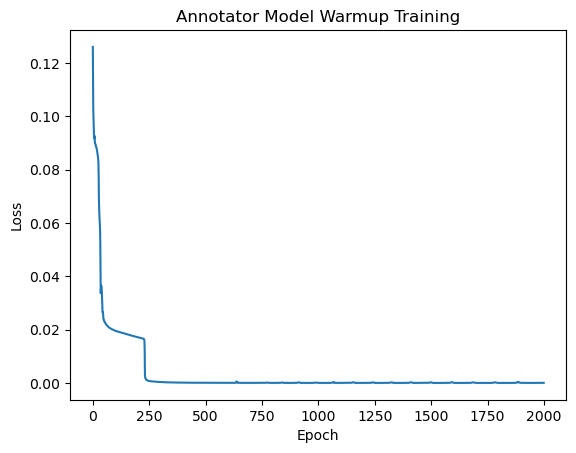

In [16]:
set_seed(seed)
annotator_model = Annotator(input_dim,H_dim,output_dim)
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    annotator_model, W_optimal,loss_list = annotator_warmup(annotator_model,x_boot, y_annot_boot,batch_size=warmup_batchsize,n_epochs = annot_epochs_warmup,learning_rate=annot_lr_warmup,device = device)
    annot_eval_after_warmup(annotator_model, BOOT, data_a_KB,average=f1_average)

    ## assign seed on LR
    classifier_model_AM = LR(max_iter = max_iter)  ## Classifier to be trained on Annotator Model Labels
    classifier_model_WO = LR(max_iter = max_iter)  ## Classifier to be trained based on Optimal Weights
    classifier_model_M = LR(max_iter = max_iter)  ## Classifier to be trained on Majority Labels
    classifier_model_TL = LR(max_iter = max_iter) ## Classifier to be trained on True Labels of chosen instances
    Classifiers = [classifier_model_AM,classifier_model_WO,classifier_model_M, classifier_model_TL]
    Classifiers,Classifiers_y_boot = warmedup_classifiers(Classifiers,BOOT,annotator_model,W_optimal)

    classf_eval_after_warmup(Classifiers,BOOT,VAL,data_c_KB,average=f1_average)

Knowledge_Base = dict()
index_frame = x_boot.index.values.tolist()
for index,data in zip(index_frame,x_boot.to_numpy()):
    data = torch.tensor(data,dtype=torch.float32)
    output = annotator_model(data)
    annot_index = torch.argmax(output,dim=0).item() ## CHECK WITH WEIGHT THRESHOLD ,Example 0.8 ETC
    if annot_index in Knowledge_Base:
        Knowledge_Base[annot_index]['index'].append(index)
        Knowledge_Base[annot_index]['label'].append(y_annot_boot.loc[index][annot_index])
    else:
        Knowledge_Base[annot_index] = dict()
        Knowledge_Base[annot_index]['index'] = [index]
        Knowledge_Base[annot_index]['label'] = [y_annot_boot.loc[index][annot_index]]
        Knowledge_Base[annot_index]['similar_instances'] = dict()

In [17]:
print('Knowledge_Base Composition after Warm-Up')
print(Knowledge_Base)

Knowledge_Base Composition after Warm-Up
{0: {'index': [301, 390, 206, 64], 'label': [2, 4, 2, 1], 'similar_instances': {}}, 3: {'index': [252], 'label': [3], 'similar_instances': {}}, 1: {'index': [136, 482], 'label': [1, 5], 'similar_instances': {}}, 2: {'index': [371], 'label': [0], 'similar_instances': {}}}


In [18]:
Classifiers, annotator_model,idx,collected_active_data,similar_instances,loss, inst_annot,full, c_a, c_f = AL_train_cycle_KB(Classifiers,Classifiers_y_boot,annotator_model,Knowledge_Base,TRAIN.copy(),BOOT.copy(),ACTIVE.copy(),VAL.copy(),W_optimal,budget, batch_size,\
         n_epochs = annot_epochs_train, learning_rate = annot_lr_train,scheme = 1,RL_flag = 0, ee_ratio = 0, label_choice=1, similarity_threshold = s_t,weight_threshold = w_t, device = device) 
new_active_x,new_active_y_true,new_active_y_annot,new_active_y,new_active_y_opt,new_active_y_majority,new_active_w,new_active_mask = collected_active_data

## DESCRIPTION

# new_active_x : Selected Instance Features
# new_active_y : Labels from annotator Model for selected Instances
# new_active_y_true : True Labels for all selected Instances
# new_active_y_opt : Labels corresponding to W Optimal for selected Instances 
# new_active_y_majority : Labels corresponsing to Majority for selected Instances 
# new_active_w : Optimal Weights calculated using Linear Programming for selected Instances 
# new_active_mask : Annotators Queried for selected Instances
# new_active_y_annot : All Annotator Labels for selected Instances

Progress Bar :  25%|██▌       | 60/236 [04:48<17:22,  5.92s/it]

In [10]:
# Append-adds at last
file = open(txt_path,"a")#append mode
file.write('\n\n\nTotal number of Active Learning Instances : '+ str(new_active_x.shape[0])+"\n")
file.close()

print('Total number of Active Learning Instances : ',new_active_x.shape[0])

count = 0
for annot_base in Knowledge_Base.keys():
    for key in Knowledge_Base[annot_base]['similar_instances'].keys():
        count += len(Knowledge_Base[annot_base]['similar_instances'][key]['index'])

# Append-adds at last
file = open(txt_path,"a")#append mode
file.write('\n\n\nExtra instances added due to knowledge base similarity : '+ str(count) + "\n")
file.close()
print('Extra instances added due to knowledge base similarity : ',count)

Total number of Active Learning Instances :  146
Extra instances added due to knowledge base similarity :  54


In [11]:
Knowledge_Base_Metrics(Knowledge_Base,new_active_y_true,Path_results,txt_path,average=f1_average)


KNOWLEDGE BASE METRIC

Size of Annotator Knowledge Base  1  :  38
Accuracy Score of Annotator Knowledge Base  1  :  0.8421052631578947
F1 Score of Annotator Knowledge Base  1  :  0.8344725449988607

Size of Annotator Knowledge Base  2  :  26
Accuracy Score of Annotator Knowledge Base  2  :  0.8846153846153846
F1 Score of Annotator Knowledge Base  2  :  0.9078144078144077

Size of Annotator Knowledge Base  3  :  27
Accuracy Score of Annotator Knowledge Base  3  :  0.8888888888888888
F1 Score of Annotator Knowledge Base  3  :  0.7441558441558441

Size of Annotator Knowledge Base  4  :  15
Accuracy Score of Annotator Knowledge Base  4  :  0.9333333333333333
F1 Score of Annotator Knowledge Base  4  :  0.9199999999999999


SIMILAR INSTANCES METRIC

Number of similar instances to instance  64  :  4
Accuracy Score of instances similar to instance  64  :  0.0
F1 Score of instances similar to instance  64  :  0.0
Annotator Base :  0

Number of similar instances to instance  116  :  2
Accuracy 

ON TRAINING DATA 
ANNOTATOR MODEL PREDICTED LABELS VS TRUE LABELS

Accuracy :  0.7671232876712328

F1 Score :  0.754775320188854

Confusion Matrix
[[24  0  0  0  0  0  2]
 [ 0 13  0  0  5  0  0]
 [ 3  0 23  0  0  0  1]
 [ 0  1  2  7  0  0  1]
 [ 3  1  0  0 24  0  4]
 [ 0  4  1  0  0  7  0]
 [ 1  0  2  1  2  0 14]]

Classification Report
              precision    recall  f1-score   support

           0       0.77      0.92      0.84        26
           1       0.68      0.72      0.70        18
           2       0.82      0.85      0.84        27
           3       0.88      0.64      0.74        11
           4       0.77      0.75      0.76        32
           5       1.00      0.58      0.74        12
           6       0.64      0.70      0.67        20

    accuracy                           0.77       146
   macro avg       0.80      0.74      0.75       146
weighted avg       0.78      0.77      0.77       146



W OPTIMAL LABELS VS TRUE LABELS

Accuracy :  0.657534246575342

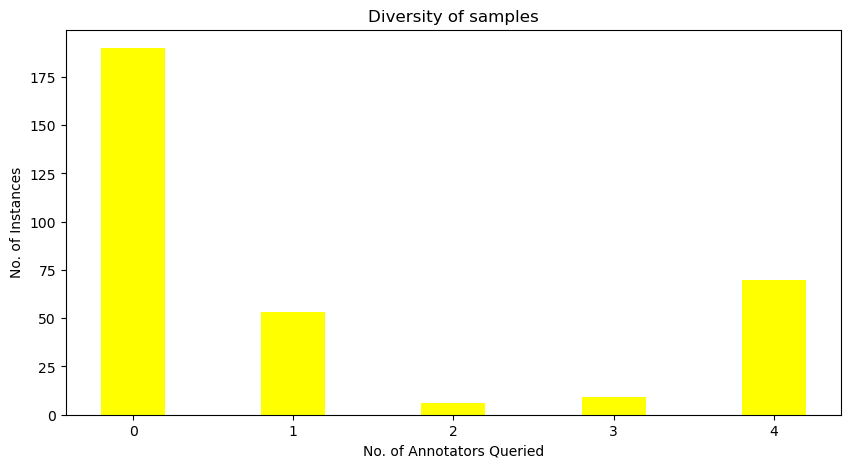

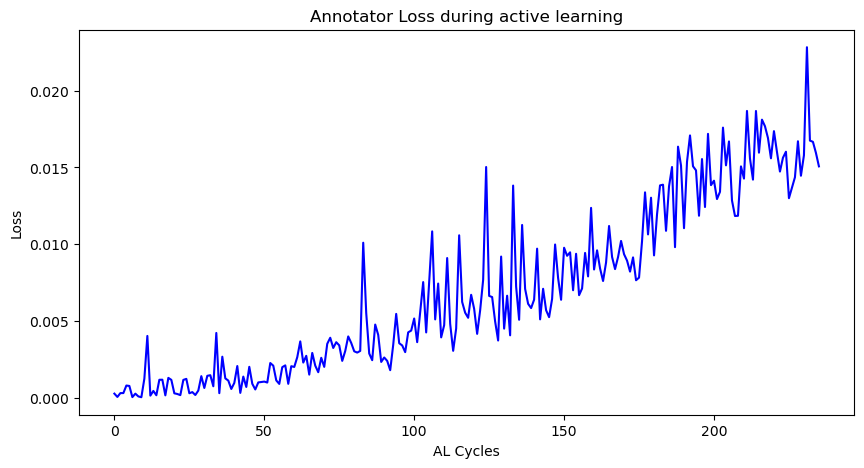

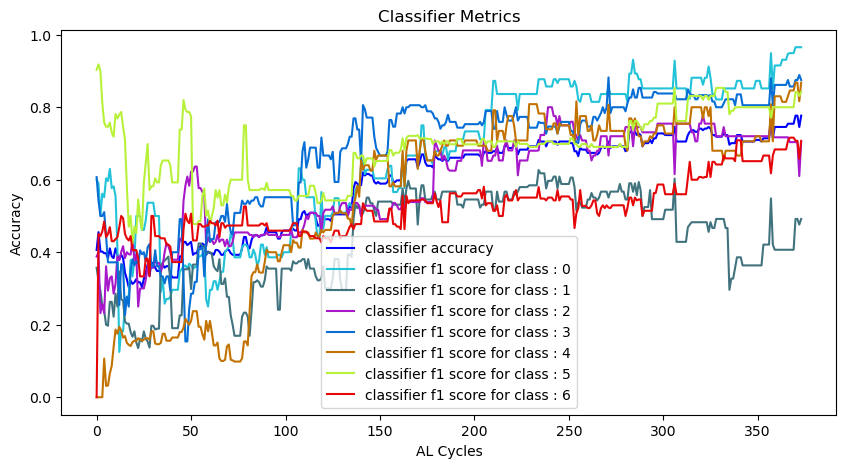

In [12]:
print('ON TRAINING DATA ')

compare_true_label(new_active_y,new_active_y_opt,new_active_y_majority,new_active_y_true,average=f1_average)

diverse_samples(inst_annot,full,Path_results)

annotator_AL_loss(loss,Path_results)

classifier_Val_scores_during_AL(c_a,c_f,Path_results)

with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    annot_eval_after_training(annotator_model,new_active_x,new_active_y_true,new_active_y_annot,new_active_mask,data_a_KB,average=f1_average)
    classf_eval_after_training(Classifiers,new_active_x,new_active_y_opt,new_active_y_majority,new_active_y_true,VAL.copy(),data_c_KB,average=f1_average)

In [13]:
df_c_KB = pd.DataFrame(data_c_KB,index = ['Annotator Model', 'W Optimal', 'Majority','True Labels'])
df_c_KB

,After Warmup Accuracy on Boot Data,After Warmup F1 Score on Boot Data,After Warmup Accuracy on Validation Data,After Warmup F1 Score on Validation Data,After Training Accuracy on Validation Data,After Training F1 Score on Validation Data
Annotator Model,0.75,0.666667,0.348214,0.345996,0.776786,0.779053
W Optimal,0.75,0.666667,0.348214,0.345996,0.745536,0.740503
Majority,1.00,1.000000,0.517857,0.513182,0.830357,0.831630
True Labels,1.00,1.000000,0.517857,0.513182,0.901786,0.904034


In [14]:
df_a_KB = pd.DataFrame(data_a_KB,index=['Weighted Average','Maximum Index'])
df_a_KB

,Annotator Accuracy after Warmup on Boot Data,Annotator F1 Score after Warmup on Boot Data,Annotator Accuracy after Training,Annotator F1 Score after Training
Weighted Average,0.50,0.500000,0.602740,0.599565
Maximum Index,0.75,0.666667,0.678082,0.672895


In [269]:
path1 = os.path.join(Path_results,"Classifier_Metrics.csv")
path2 = os.path.join(Path_results,"Annotator_Metrics.csv")
df_c_KB.to_csv(path1)
df_a_KB.to_csv(path2)

#export DataFrame to text file
with open(txt_path, 'a') as f:
    df_string_1 = df_c_KB.to_string(header=True, index=True)
    df_string_2 = df_a_KB.to_string(header=True, index=True)
    f.write("\n\n\nKNOWLEDGE BASE CLASSIFIER METRIC\n\n")
    f.write(df_string_1)
    f.write("\n\n\nKNOWLEDGE BASE ANNOTATOR METRIC\n\n")
    f.write(df_string_2)

1. Knowledge Base  - compare annotator label with ground truth....for each annotator and then average 
2. Compare Labels based on similarity metrics --- compare ground truth with label obtained from Knowledge Base for a new incoming instance 
3. label from Instance and not the Annotator list
4. USE MAP instead of DICTIONARY....make class of Knowledge Base....Annotator,instances in Annotator and its label from that annotator, make list of all instances which matched an instance in knowledge base

## OPTION 1 --- LABELS FROM ANNOTATOR MODEL ( SCHEME 1 )

Random seed set as 1


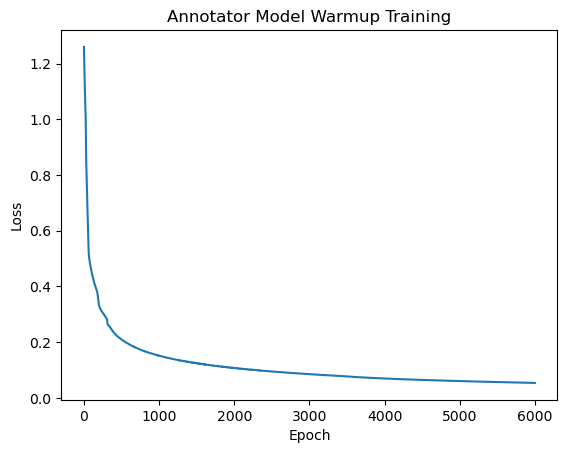

In [270]:
set_seed(seed)
annotator_model = Annotator(input_dim,H_dim,output_dim)
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    annotator_model, W_optimal,loss_list = annotator_warmup(annotator_model,x_boot, y_annot_boot,batch_size=warmup_batchsize,n_epochs = annot_epochs_warmup,learning_rate=annot_lr_warmup,device = device)
    annot_eval_after_warmup(annotator_model, BOOT, data_a_AM,average=f1_average)

    ## assign seed on LR
    classifier_model_AM = LR(max_iter = max_iter)  ## Classifier to be trained on Annotator Model Labels
    classifier_model_WO = LR(max_iter = max_iter)  ## Classifier to be trained based on Optimal Weights
    classifier_model_M = LR(max_iter = max_iter)  ## Classifier to be trained on Majority Labels
    classifier_model_TL = LR(max_iter = max_iter) ## Classifier to be trained on True Labels of chosen instances
    # classifier_model_1 = PWC(num_class)
    # classifier_model_2 = PWC(num_class)
    # classifier_model_3 = PWC(num_class)
    # classifier_model_4 = PWC(num_class)
    Classifiers = [classifier_model_AM,classifier_model_WO,classifier_model_M, classifier_model_TL]
    Classifiers,Classifiers_y_boot = warmedup_classifiers(Classifiers,BOOT,annotator_model,W_optimal)

    classf_eval_after_warmup(Classifiers,BOOT,VAL,data_c_AM,average=f1_average)

In [271]:
Classifiers, annotator_model,idx,collected_active_data,loss, inst_annot,full, c_a, c_f = AL_train_cycle(Classifiers,Classifiers_y_boot,annotator_model,BOOT.copy(),ACTIVE.copy(),VAL.copy(),W_optimal,budget, batch_size,\
         n_epochs = annot_epochs_train, learning_rate = annot_lr_train, scheme = 1, RL_flag = 0, ee_ratio = 0,label_choice = 1, device = device) 
new_active_x,new_active_y_true,new_active_y_annot,new_active_y,new_active_y_opt,new_active_y_majority,new_active_w,new_active_mask = collected_active_data

## DESCRIPTION

# new_active_x : Selected Instance Features
# new_active_y : Labels from annotator Model for selected Instances
# new_active_y_true : True Labels for all selected Instances
# new_active_y_opt : Labels corresponding to W Optimal for selected Instances
# new_active_y_majority : Labels corresponsing to Majority for selected Instances
# new_active_w : Optimal Weights calculated using Linear Programming for selected Instances
# new_active_mask : Annotators Queried for selected Instances
# new_active_y_annot : All Annotator Labels for selected Instances

 53%|█████▎    | 386/724 [1:17:44<1:08:04, 12.09s/it]


KeyboardInterrupt: 

In [ ]:
print('Total number of Active Learning Instances : ',new_active_x.shape[0])

Total number of Active Learning Instances :  88


ANNOTATOR MODEL PREDICTED LABELS VS TRUE LABELS

Accuracy :  0.7613636363636364

F1 Score :  0.7614900480693221

Confusion Matrix
[[25  4  4]
 [ 4 23  1]
 [ 5  3 19]]

Classification Report
              precision    recall  f1-score   support

           0       0.74      0.76      0.75        33
           1       0.77      0.82      0.79        28
           2       0.79      0.70      0.75        27

    accuracy                           0.76        88
   macro avg       0.76      0.76      0.76        88
weighted avg       0.76      0.76      0.76        88



W OPTIMAL LABELS VS TRUE LABELS

Accuracy :  0.8181818181818182

F1 Score :  0.8175677288459243

Confusion Matrix
[[28  3  5]
 [ 2 25  0]
 [ 4  2 19]]

Classification Report
              precision    recall  f1-score   support

           0       0.82      0.78      0.80        36
           1       0.83      0.93      0.88        27
           2       0.79      0.76      0.78        25

    accuracy                       

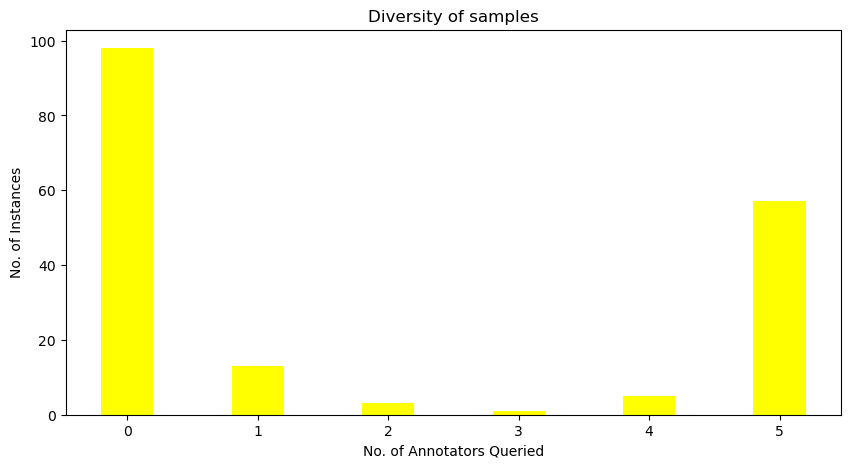

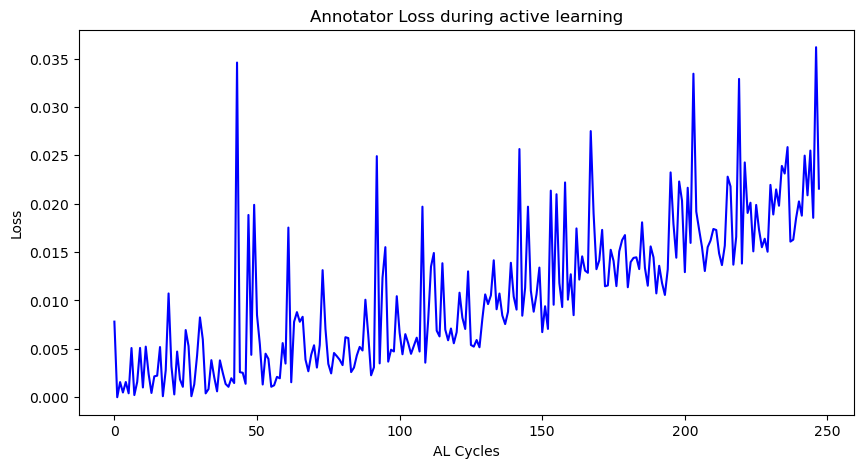

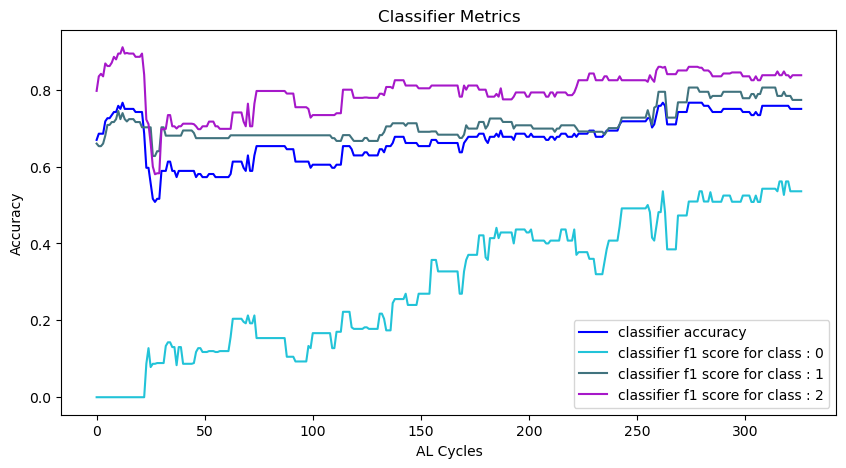

In [ ]:
compare_true_label(new_active_y,new_active_y_opt,new_active_y_majority,new_active_y_true,average=f1_average)

diverse_samples(inst_annot,full,None)

annotator_AL_loss(loss,None)

classifier_Val_scores_during_AL(c_a,c_f,None)

with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    annot_eval_after_training(annotator_model,new_active_x,new_active_y_true,new_active_y_annot,new_active_mask,data_a_AM,average=f1_average)
    classf_eval_after_training(Classifiers,new_active_x,new_active_y_opt,new_active_y_majority,new_active_y_true,VAL.copy(),data_c_AM,average=f1_average)

CLASSIFIER METRICS AFTER ACTIVE LEARNING TRAINING CYCLE

In [ ]:
df_c_AM = pd.DataFrame(data_c_AM,index = ['Annotator Model', 'W Optimal', 'Majority','True Labels'])
df_c_AM

,After Warmup Accuracy on Boot Data,After Warmup F1 Score on Boot Data,After Warmup Accuracy on Validation Data,After Warmup F1 Score on Validation Data,After Training Accuracy on Validation Data,After Training F1 Score on Validation Data
Annotator Model,0.777778,0.582011,0.693548,0.499371,0.750000,0.715551
W Optimal,0.888889,0.851852,0.685484,0.576121,0.733871,0.706156
Majority,0.888889,0.851852,0.685484,0.576121,0.677419,0.663175
True Labels,1.000000,1.000000,0.790323,0.746418,0.862903,0.818884


ANNOTATOR METRICS AFTER ACTIVE LEARNING TRAINING CYCLE

In [ ]:
df_a_AM = pd.DataFrame(data_a_AM,index=['Weighted Average','Maximum Index'])
df_a_AM

,Annotator Accuracy after Warmup on Boot Data,Annotator F1 Score after Warmup on Boot Data,Annotator Accuracy after Training,Annotator F1 Score after Training
Weighted Average,0.777778,0.582011,0.738636,0.743627
Maximum Index,0.777778,0.582011,0.750000,0.753431


In [ ]:
#export DataFrame to text file
with open(txt_path, 'a') as f:
    df_string_1 = df_c_AM.to_string(header=True, index=True)
    df_string_2 = df_a_AM.to_string(header=True, index=True)
    f.write("\n\n\nWITHOUT KNOWLEDGE BASE CLASSIFIER METRIC\n\n")
    f.write(df_string_1)
    f.write("\n\n\nWITHOUT KNOWLEDGE BASE ANNOTATOR METRIC\n\n")
    f.write(df_string_2)

## OPTION 2 --- LABELS CHOSEN USING W OPTIMAL ( SCHEME 2 )

Random seed set as 1


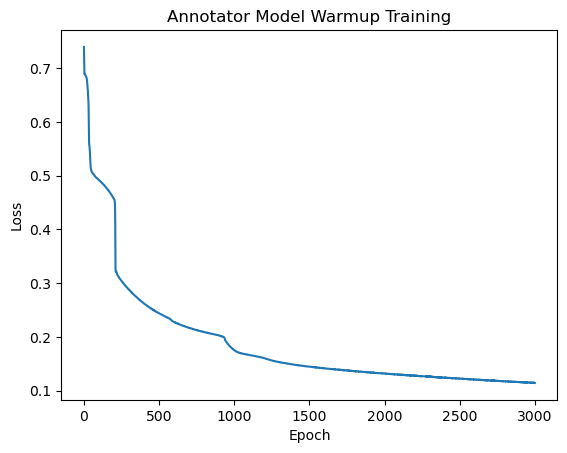

In [132]:
set_seed(seed)
annotator_model = Annotator_2(input_dim,H_dim,output_dim)
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    annotator_model, W_optimal,loss_list = annotator_warmup(annotator_model,x_boot, y_annot_boot,batch_size=warmup_batchsize,n_epochs = annot_epochs_warmup,learning_rate = annot_lr_warmup,device = device)
    annot_eval_after_warmup(annotator_model, BOOT, data_a_WO)

classifier_model_AM = LR(max_iter = max_iter)  ## Classifier to be trained on Annotator Model Labels
classifier_model_WO = LR(max_iter = max_iter)  ## Classifier to be trained based on Optimal Weights
classifier_model_M = LR(max_iter = max_iter)  ## Classifier to be trained on Majority Labels
classifier_model_TL = LR(max_iter = max_iter) ## Classifier to be trained on True Labels of chosen instances
# classifier_model_1 = PWC(num_class)
# classifier_model_2 = PWC(num_class)
# classifier_model_3 = PWC(num_class)
# classifier_model_4 = PWC(num_class)
Classifiers = [classifier_model_AM,classifier_model_WO,classifier_model_M, classifier_model_TL]
Classifiers,Classifiers_y_boot = warmedup_classifiers(Classifiers,BOOT,annotator_model,W_optimal)

classf_eval_after_warmup(Classifiers,BOOT,VAL,data_c_WO)

In [24]:
Classifiers, annotator_model,idx,collected_active_data,loss, inst_annot,full, c_a, c_f = AL_train_cycle(Classifiers,Classifiers_y_boot,annotator_model,BOOT.copy(),ACTIVE.copy(),VAL.copy(),W_optimal,budget, batch_size,\
         n_epochs = annot_epochs_train, learning_rate = annot_lr_train,scheme = 2, RL_flag = 0, ee_ratio = 0, label_choice = 1, device = device) 
new_active_x,new_active_y_true,new_active_y_annot,new_active_y,new_active_y_opt,new_active_y_majority,new_active_w,new_active_mask = collected_active_data

## DESCRIPTION

# new_active_x : Selected Instance Features
# new_active_y : Labels from annotator Model for selected Instances
# new_active_y_true : True Labels for all selected Instances
# new_active_y_opt : Labels corresponding to W Optimal for selected Instances
# new_active_y_majority : Labels corresponsing to Majority for selected Instances
# new_active_w : Optimal Weights calculated using Linear Programming for selected Instances
# new_active_mask : Annotators Queried for selected Instances
# new_active_y_annot : All Annotator Labels for selected Instances

 31%|███▏      | 150/478 [07:05<15:29,  2.83s/it]


KeyboardInterrupt: 

ANNOTATOR MODEL PREDICTED LABELS VS TRUE LABELS

Accuracy :  0.625

F1 Score :  [0.47058824 0.68292683 0.63636364]

Confusion Matrix
[[ 4  7  2]
 [ 0 14  0]
 [ 0  6  7]]

Classification Report
              precision    recall  f1-score   support

           0       1.00      0.31      0.47        13
           1       0.52      1.00      0.68        14
           2       0.78      0.54      0.64        13

    accuracy                           0.62        40
   macro avg       0.77      0.62      0.60        40
weighted avg       0.76      0.62      0.60        40



W OPTIMAL LABELS VS TRUE LABELS

Accuracy :  0.75

F1 Score :  [0.8        0.7826087  0.66666667]

Confusion Matrix
[[ 4  2  0]
 [ 0 18  1]
 [ 0  7  8]]

Classification Report
              precision    recall  f1-score   support

           0       1.00      0.67      0.80         6
           1       0.67      0.95      0.78        19
           2       0.89      0.53      0.67        15

    accuracy                  

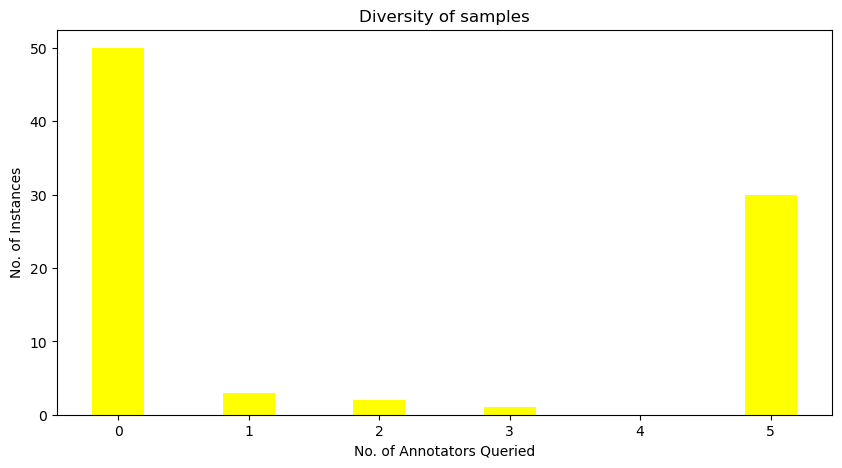

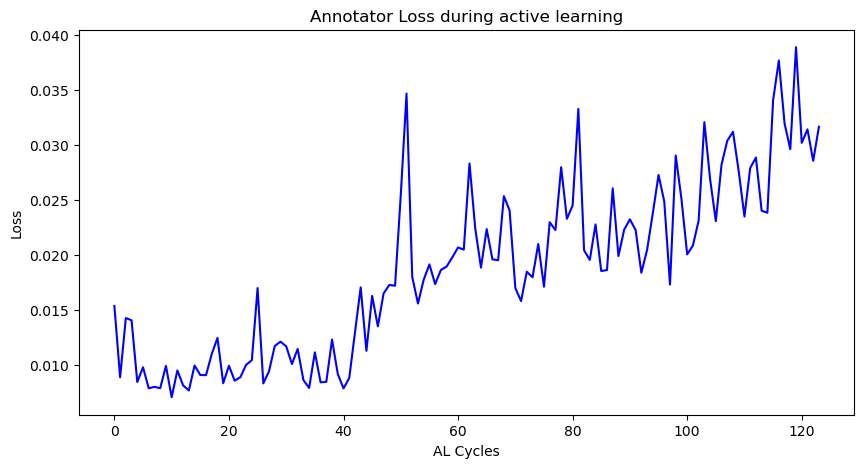

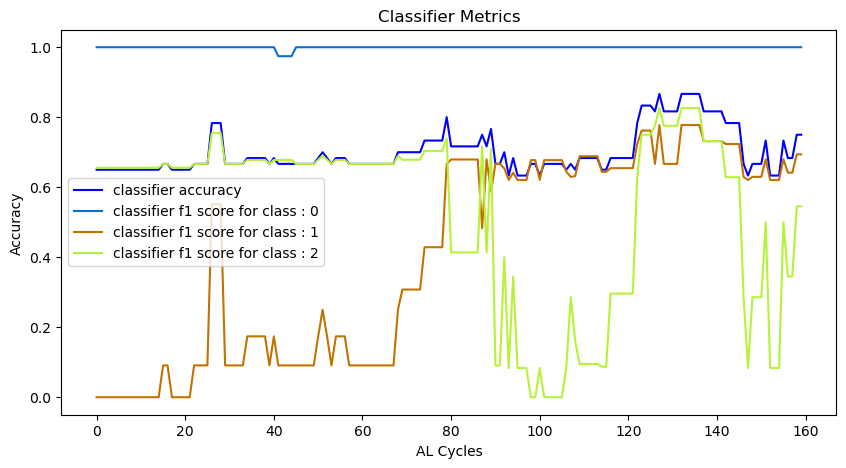

In [ ]:
compare_true_label(new_active_y,new_active_y_opt,new_active_y_majority,new_active_y_true)

diverse_samples(inst_annot,full,None)

annotator_AL_loss(loss,None)

classifier_Val_scores_during_AL(c_a,c_f,None)

with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    annot_eval_after_training(annotator_model,new_active_x,new_active_y_true,new_active_y_annot,new_active_mask,data_a_WO)
    classf_eval_after_training(Classifiers,new_active_x,new_active_y_opt,new_active_y_majority,new_active_y_true,VAL.copy(),data_c_WO)

CLASSIFIER METRICS AFTER ACTIVE LEARNING TRAINING CYCLE

In [ ]:
df_c_WO = pd.DataFrame(data_c_WO,index = ['Annotator Model', 'W Optimal', 'Majority','True Labels'])
df_c_WO

,After Warmup Accuracy on Boot Data,After Warmup F1 Score on Boot Data,After Warmup Accuracy on Validation Data,After Warmup F1 Score on Validation Data,After Training Accuracy on Validation Data,After Training F1 Score on Validation Data
Annotator Model,0.75,"[1.0, 0.0, 0.6666666666666666]",0.650000,"[1.0, 0.0, 0.6557377049180327]",0.683333,"[0.9743589743589743, 0.5581395348837208, 0.526..."
W Optimal,0.75,"[1.0, 0.0, 0.6666666666666666]",0.650000,"[1.0, 0.0, 0.6557377049180327]",0.750000,"[1.0, 0.6938775510204083, 0.5454545454545455]"
Majority,1.00,"[1.0, 1.0, 1.0]",0.783333,"[0.9743589743589743, 0.5517241379310345, 0.769...",0.950000,"[0.9743589743589743, 0.9302325581395349, 0.947..."
True Labels,1.00,"[1.0, 1.0, 1.0]",0.783333,"[0.9743589743589743, 0.5517241379310345, 0.769...",0.966667,"[1.0, 0.9545454545454545, 0.9473684210526316]"


ANNOTATOR METRICS AFTER ACTIVE LEARNING TRAINING CYCLE

In [ ]:
df_a_WO = pd.DataFrame(data_a_WO,index=['Weighted Average','Maximum Index'])
df_a_WO

,Annotator Accuracy after Warmup on Boot Data,Annotator F1 Score after Warmup on Boot Data,Annotator Accuracy after Training,Annotator F1 Score after Training
Weighted Average,0.75,"[1.0, 0.0, 0.6666666666666666]",0.525,"[0.375, 0.5909090909090909, 0.5]"
Maximum Index,0.75,"[1.0, 0.0, 0.6666666666666666]",0.675,"[0.47058823529411764, 0.6976744186046512, 0.79..."


## OPTION 3 --- EXPLORATION EXPLOITATION USING LABELS FROM ANNOTATOR MODEL ( SCHEME 1 )

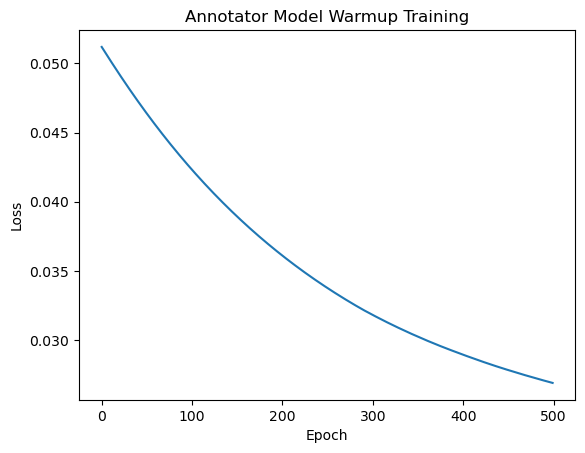

In [ ]:
set_seed(seed)
annotator_model = Annotator_2(input_dim,H_dim,output_dim)
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    annotator_model, W_optimal,loss_list = annotator_warmup(annotator_model,x_boot, y_annot_boot,batch_size=warmup_batchsize,n_epochs = annot_epochs_warmup,learning_rate = annot_lr_warmup,device = device)
    annot_eval_after_warmup(annotator_model, BOOT, data_a_AM_EE)

classifier_model_AM = LR(max_iter = max_iter)  ## Classifier to be trained on Annotator Model Labels
classifier_model_WO = LR(max_iter = max_iter)  ## Classifier to be trained based on Optimal Weights
classifier_model_M = LR(max_iter = max_iter)  ## Classifier to be trained on Majority Labels
classifier_model_TL = LR(max_iter = max_iter) ## Classifier to be trained on True Labels of chosen instances
# classifier_model_1 = PWC(num_class)
# classifier_model_2 = PWC(num_class)
# classifier_model_3 = PWC(num_class)
# classifier_model_4 = PWC(num_class)
Classifiers = [classifier_model_AM,classifier_model_WO,classifier_model_M, classifier_model_TL]
Classifiers,Classifiers_y_boot = warmedup_classifiers(Classifiers,BOOT,annotator_model,W_optimal)

classf_eval_after_warmup(Classifiers,BOOT,VAL,data_c_AM_EE)

In [ ]:
Classifiers, annotator_model,idx,collected_active_data,loss, inst_annot,full, c_a, c_f = AL_train_cycle(Classifiers,Classifiers_y_boot,annotator_model,BOOT.copy(),ACTIVE.copy(),VAL.copy(),W_optimal,budget, batch_size,\
         n_epochs = annot_epochs_train, learning_rate = annot_lr_train, scheme = 1, RL_flag = 1, ee_ratio = 0.7, label_choice = 1, device = device) 
new_active_x,new_active_y_true,new_active_y_annot,new_active_y,new_active_y_opt,new_active_y_majority,new_active_w,new_active_mask = collected_active_data

## DESCRIPTION

# new_active_x : Selected Instance Features
# new_active_y : Labels from annotator Model for selected Instances
# new_active_y_true : True Labels for all selected Instances
# new_active_y_opt : Labels corresponding to W Optimal for selected Instances
# new_active_y_majority : Labels corresponsing to Majority for selected Instances
# new_active_w : Optimal Weights calculated using Linear Programming for selected Instances
# new_active_mask : Annotators Queried for selected Instances
# new_active_y_annot : All Annotator Labels for selected Instances

100%|██████████| 160/160 [00:01<00:00, 80.21it/s]


ANNOTATOR MODEL PREDICTED LABELS VS TRUE LABELS

Accuracy :  0.7450980392156863

F1 Score :  [0.79166667 0.81818182 0.2       ]

Confusion Matrix
[[19  3  0]
 [ 2 18  1]
 [ 5  2  1]]

Classification Report
              precision    recall  f1-score   support

           0       0.73      0.86      0.79        22
           1       0.78      0.86      0.82        21
           2       0.50      0.12      0.20         8

    accuracy                           0.75        51
   macro avg       0.67      0.62      0.60        51
weighted avg       0.72      0.75      0.71        51



W OPTIMAL LABELS VS TRUE LABELS

Accuracy :  0.7647058823529411

F1 Score :  [0.82608696 0.7826087  0.4       ]

Confusion Matrix
[[19  1  0]
 [ 5 18  0]
 [ 2  4  2]]

Classification Report
              precision    recall  f1-score   support

           0       0.73      0.95      0.83        20
           1       0.78      0.78      0.78        23
           2       1.00      0.25      0.40         8

   

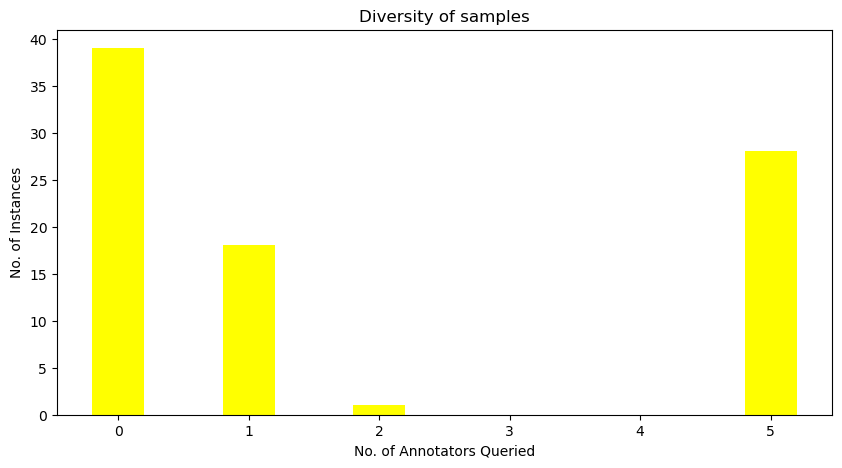

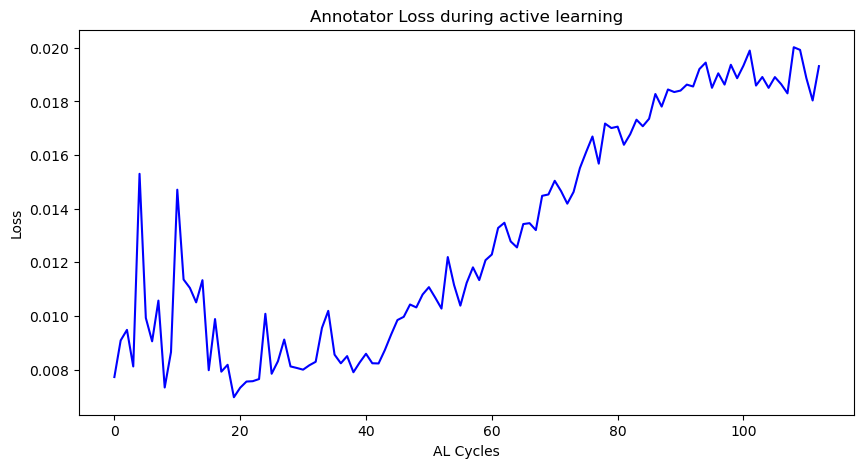

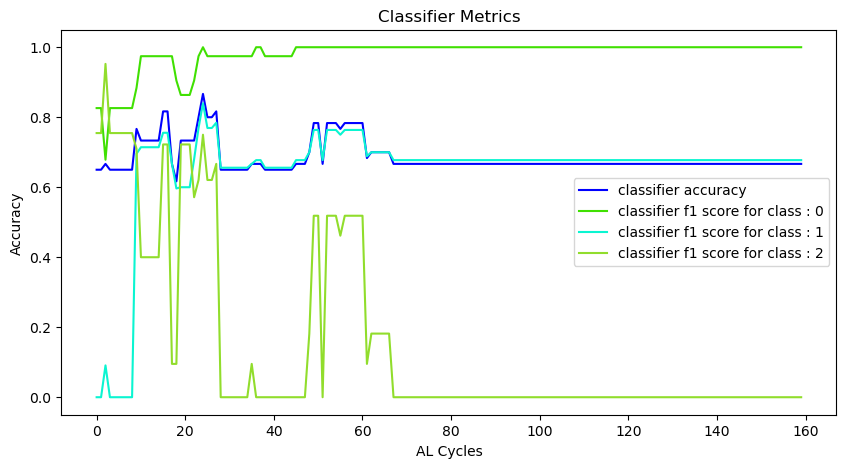

In [ ]:
compare_true_label(new_active_y,new_active_y_opt,new_active_y_majority,new_active_y_true)

diverse_samples(inst_annot,full,None)

annotator_AL_loss(loss,None)

classifier_Val_scores_during_AL(c_a,c_f,None)

with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    annot_eval_after_training(annotator_model,new_active_x,new_active_y_true,new_active_y_annot,new_active_mask,data_a_AM_EE)
    classf_eval_after_training(Classifiers,new_active_x,new_active_y_opt,new_active_y_majority,new_active_y_true,VAL.copy(),data_c_AM_EE)

CLASSIFIER METRICS AFTER ACTIVE LEARNING TRAINING CYCLE WITH EXPLOITATION EXPLORATION RATIO

In [ ]:
df_c_AM_EE = pd.DataFrame(data_c_AM_EE,index = ['Annotator Model', 'W Optimal', 'Majority','True Labels'])
df_c_AM_EE

,After Warmup Accuracy on Boot Data,After Warmup F1 Score on Boot Data,After Warmup Accuracy on Validation Data,After Warmup F1 Score on Validation Data,After Training Accuracy on Validation Data,After Training F1 Score on Validation Data
Annotator Model,0.75,"[0.8, 0.0, 1.0]",0.650000,"[0.6551724137931034, 0.0, 0.975609756097561]",0.666667,"[1.0, 0.6774193548387097, 0.0]"
W Optimal,0.75,"[1.0, 0.0, 0.6666666666666666]",0.650000,"[1.0, 0.0, 0.6557377049180327]",0.666667,"[1.0, 0.6774193548387097, 0.0]"
Majority,1.00,"[1.0, 1.0, 1.0]",0.783333,"[0.9743589743589743, 0.5517241379310345, 0.769...",0.666667,"[1.0, 0.6774193548387097, 0.0]"
True Labels,1.00,"[1.0, 1.0, 1.0]",0.783333,"[0.9743589743589743, 0.5517241379310345, 0.769...",0.716667,"[1.0, 0.711864406779661, 0.2608695652173913]"


ANNOTATOR METRICS AFTER ACTIVE LEARNING TRAINING CYCLE WITH EXPLOITATION EXPLORATION RATIO 

In [ ]:
df_a_AM_EE = pd.DataFrame(data_a_AM_EE,index=['Weighted Average','Maximum Index'])
df_a_AM_EE

,Annotator Accuracy after Warmup on Boot Data,Annotator F1 Score after Warmup on Boot Data,Annotator Accuracy after Training,Annotator F1 Score after Training
Weighted Average,0.75,"[0.8, 0.0, 1.0]",0.725490,"[0.7391304347826088, 0.8372093023255814, 0.307..."
Maximum Index,0.75,"[0.8, 0.0, 1.0]",0.705882,"[0.7346938775510203, 0.7804878048780488, 0.333..."


## OPTION 4 --- MAJORITY LABELS

Random seed set as 1


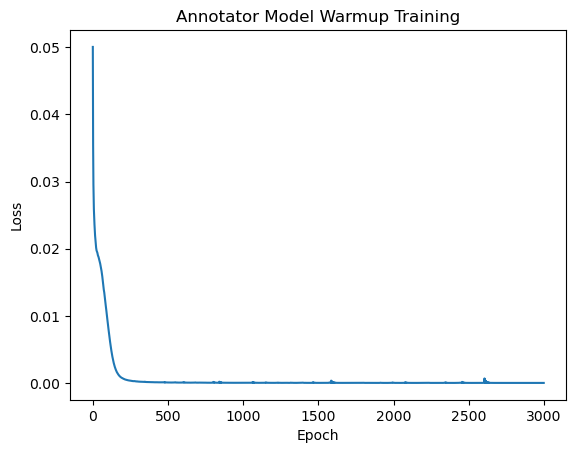

In [32]:
set_seed(seed)
annotator_model = Annotator(input_dim,H_dim,output_dim)
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    annotator_model, W_optimal,loss_list = annotator_warmup(annotator_model,x_boot, y_annot_boot,batch_size = warmup_batchsize, n_epochs = annot_epochs_warmup,learning_rate = annot_lr_warmup,device = 'cpu')
    annot_eval_after_warmup(annotator_model, BOOT, data_a_M,average=f1_average)
    
classifier_model_AM = LR(max_iter = max_iter)  ## Classifier to be trained on Annotator Model Labels
classifier_model_WO = LR(max_iter = max_iter)  ## Classifier to be trained based on Optimal Weights
classifier_model_M = LR(max_iter = max_iter)  ## Classifier to be trained on Majority Labels
classifier_model_TL = LR(max_iter = max_iter) ## Classifier to be trained on True Labels of chosen instances
# classifier_model_1 = PWC(num_class)
# classifier_model_2 = PWC(num_class)
# classifier_model_3 = PWC(num_class)
# classifier_model_4 = PWC(num_class)
Classifiers = [classifier_model_AM,classifier_model_WO,classifier_model_M, classifier_model_TL]
Classifiers,Classifiers_y_boot = warmedup_classifiers(Classifiers,BOOT,annotator_model,W_optimal)

classf_eval_after_warmup(Classifiers,BOOT,VAL,data_c_M,average=f1_average)

In [33]:
Classifiers,idx,collected_data,loss, inst_annot,full, c_a, c_f = AL_train_majority(Classifiers,Classifiers_y_boot,BOOT.copy(),ACTIVE.copy(),VAL.copy(),W_optimal,budget, batch_size,\
         n_epochs = annot_epochs_train, learning_rate = annot_lr_train, device = device)
new_active_x,new_active_y_true,new_active_y_annot,new_active_y,new_active_y_opt,new_active_y_majority,new_active_w,new_active_mask = collected_data
## DESCRIPTION

# new_active_x : Selected Instance Features
# new_active_y : Labels from annotator Model for selected Instances
# new_active_y_true : True Labels for all selected Instances
# new_active_y_opt : Labels corresponding to W Optimal for selected Instances
# new_active_y_majority : Labels corresponsing to Majority for selected Instances
# new_active_w : Optimal Weights calculated using Linear Programming for selected Instances
# new_active_mask : Annotators Queried for selected Instances
# new_active_y_annot : All Annotator Labels for selected Instances

100%|██████████| 160/160 [00:01<00:00, 99.05it/s] 


ANNOTATOR MODEL PREDICTED LABELS VS TRUE LABELS

Accuracy :  0.7105263157894737

F1 Score :  [0.4        0.76923077 0.74074074]

Confusion Matrix
[[ 2  4  2]
 [ 0 15  2]
 [ 0  3 10]]

Classification Report
              precision    recall  f1-score   support

           0       1.00      0.25      0.40         8
           1       0.68      0.88      0.77        17
           2       0.71      0.77      0.74        13

    accuracy                           0.71        38
   macro avg       0.80      0.63      0.64        38
weighted avg       0.76      0.71      0.68        38



W OPTIMAL LABELS VS TRUE LABELS

Accuracy :  0.7894736842105263

F1 Score :  [0.8        0.8        0.77419355]

Confusion Matrix
[[ 2  1  0]
 [ 0 16  2]
 [ 0  5 12]]

Classification Report
              precision    recall  f1-score   support

           0       1.00      0.67      0.80         3
           1       0.73      0.89      0.80        18
           2       0.86      0.71      0.77        17

   

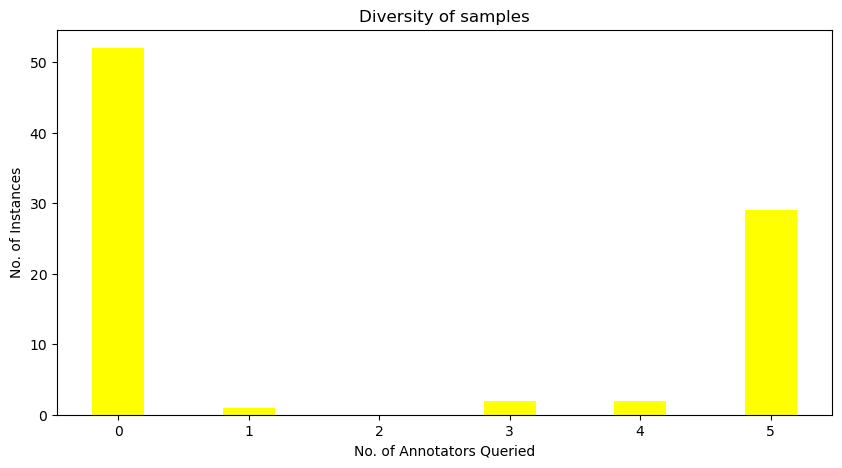

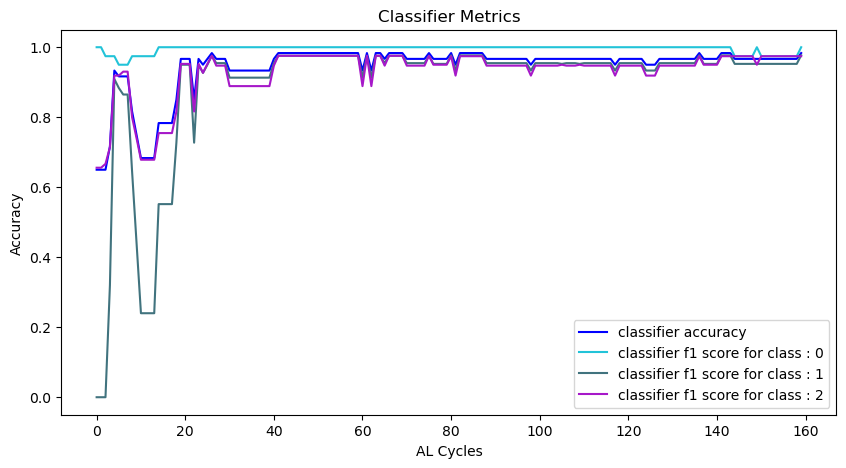

In [34]:
compare_true_label(new_active_y,new_active_y_opt,new_active_y_majority,new_active_y_true)

diverse_samples(inst_annot,full,None)

classifier_Val_scores_during_AL(c_a,c_f,None)

with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    annot_eval_after_training(annotator_model,new_active_x,new_active_y_true,new_active_y_annot,new_active_mask,data_a_M,average=f1_average)
    classf_eval_after_training(Classifiers,new_active_x,new_active_y_opt,new_active_y_majority,new_active_y_true,VAL.copy(),data_c_M,average=f1_average)

CLASSIFIER METRICS AFTER ACTIVE LEARNING CYCLE

In [35]:
df_c_M = pd.DataFrame(data_c_M[2:],index = ['Majority','True Labels'])
df_c_M

,After Warmup Accuracy on Boot Data,After Warmup F1 Score on Boot Data,After Warmup Accuracy on Validation Data,After Warmup F1 Score on Validation Data,After Training Accuracy on Validation Data,After Training F1 Score on Validation Data
Majority,1.0,1.0,0.783333,0.765105,0.983333,0.983701
True Labels,1.0,1.0,0.783333,0.765105,0.966667,0.967292


In [182]:
#export DataFrame to text file
with open(txt_path, 'a') as f:
    df_string_1 = df_c_M.to_string(header=True, index=True)
    f.write("\n\n\nWITH MAJORITY LABEL CLASSIFIER METRIC\n\n")
    f.write(df_string_1)

## OPTION 5 --- TRAIN ON INSTANCES FROM MAPAL

Random seed set as 1


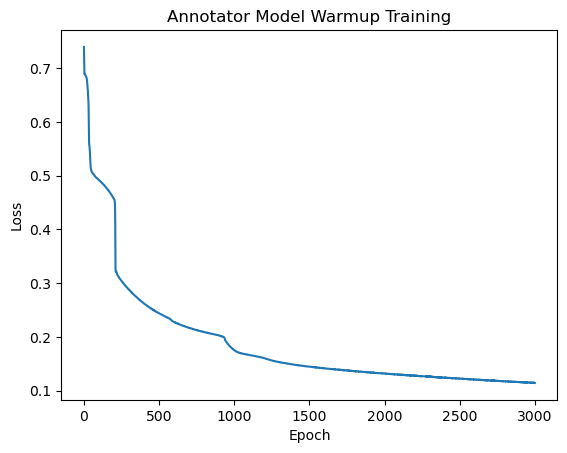

In [138]:
set_seed(seed)
annotator_model = Annotator_2(input_dim,H_dim,output_dim)
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    annotator_model, W_optimal,loss_list = annotator_warmup(annotator_model,x_boot, y_annot_boot,batch_size = warmup_batchsize, n_epochs = annot_epochs_warmup, learning_rate = annot_lr_warmup,device = device)
    annot_eval_after_warmup(annotator_model, BOOT, data_a_MAPAL)

classifier_model_AM = LR(max_iter = max_iter)  ## Classifier to be trained on Annotator Model Labels
classifier_model_WO = LR(max_iter = max_iter)  ## Classifier to be trained based on Optimal Weights
classifier_model_M = LR(max_iter = max_iter)  ## Classifier to be trained on Majority Labels
classifier_model_TL = LR(max_iter = max_iter) ## Classifier to be trained on True Labels of chosen instances
# classifier_model_1 = PWC(num_class)
# classifier_model_2 = PWC(num_class)
# classifier_model_3 = PWC(num_class)
# classifier_model_4 = PWC(num_class)
Classifiers = [classifier_model_AM,classifier_model_WO,classifier_model_M, classifier_model_TL]
Classifiers,Classifiers_y_boot = warmedup_classifiers(Classifiers,BOOT,annotator_model,W_optimal)

classf_eval_after_warmup(Classifiers,BOOT,VAL,data_c_MAPAL)

In [139]:
Classifiers, annotator_model,collected_active_data, loss, inst_annot, full, c_a,c_f = AL_train_MAPAL_instances(Classifiers,Classifiers_y_boot,annotator_model,ordered_instances,BOOT.copy(),VAL.copy(),Mapal_Data,W_optimal,budget, batch_size,\
         n_epochs = annot_epochs_train, learning_rate = annot_lr_train,label_choice = 1, device = device)
new_active_x,new_active_y,new_active_y_opt,new_active_y_majority, new_active_y_true,new_active_y_annot, new_active_mask = collected_active_data

## DESCRIPTION

# new_active_x : Selected Instance Features
# new_active_y : Labels from annotator Model for selected Instances
# new_active_y_true : True Labels for all selected Instances
# new_active_y_opt : Labels corresponding to W Optimal for selected Instances
# new_active_y_majority : Labels corresponsing to Majority for selected Instances
# new_active_w : Optimal Weights calculated using Linear Programming for selected Instances
# new_active_mask : Annotators Queried for selected Instances
# new_active_y_annot : All Annotator Labels for selected Instances

100%|██████████| 406/406 [26:40<00:00,  3.94s/it]


In [140]:
compare_true_label(new_active_y,new_active_y_opt,new_active_y_majority,new_active_y_true)

ANNOTATOR MODEL PREDICTED LABELS VS TRUE LABELS

Accuracy :  0.594855305466238

F1 Score :  [0.53623188 0.54135338 0.67676768 0.58823529]

Confusion Matrix
[[37 12 11  9]
 [10 36 11 13]
 [12  7 67 10]
 [10  8 13 45]]

Classification Report
              precision    recall  f1-score   support

           0       0.54      0.54      0.54        69
           1       0.57      0.51      0.54        70
           2       0.66      0.70      0.68        96
           3       0.58      0.59      0.59        76

    accuracy                           0.59       311
   macro avg       0.59      0.59      0.59       311
weighted avg       0.59      0.59      0.59       311



W OPTIMAL LABELS VS TRUE LABELS

Accuracy :  0.6237942122186495

F1 Score :  [0.60150376 0.55474453 0.67336683 0.64052288]

Confusion Matrix
[[40  9  9  6]
 [10 38 13 13]
 [13  8 67  9]
 [ 6  8 13 49]]

Classification Report
              precision    recall  f1-score   support

           0       0.58      0.62      0.60

In [141]:
print((new_active_y_majority==new_active_y_opt).sum())
print((new_active_y==new_active_y_opt).sum())
print((new_active_y==new_active_y_majority).sum())

0    279
dtype: int64
0    279
dtype: int64
0    274
dtype: int64


In [142]:
print('USING MAPAL SELECTED INSTANCES')
print_scores(Classifiers,VAL)

USING MAPAL SELECTED INSTANCES

Labels from Annotator Model
Accuracy :  0.6371681415929203
F1 Score :  [0.82926829 0.36619718 0.61835749 0.7030303 ]
[[68  4  4  6]
 [ 5 26 10  9]
 [ 6 45 64  6]
 [ 3 17  8 58]]
              precision    recall  f1-score   support

           0       0.83      0.83      0.83        82
           1       0.28      0.52      0.37        50
           2       0.74      0.53      0.62       121
           3       0.73      0.67      0.70        86

    accuracy                           0.64       339
   macro avg       0.65      0.64      0.63       339
weighted avg       0.69      0.64      0.65       339


Labels from W optimal
Accuracy :  0.6430678466076696
F1 Score :  [0.82926829 0.39455782 0.59330144 0.74683544]
[[68  6  3  5]
 [ 2 29 14 10]
 [10 46 62  5]
 [ 2 11  7 59]]
              precision    recall  f1-score   support

           0       0.83      0.83      0.83        82
           1       0.32      0.53      0.39        55
           2       

[1, 2, 3, 4] [193, 69, 21, 3]


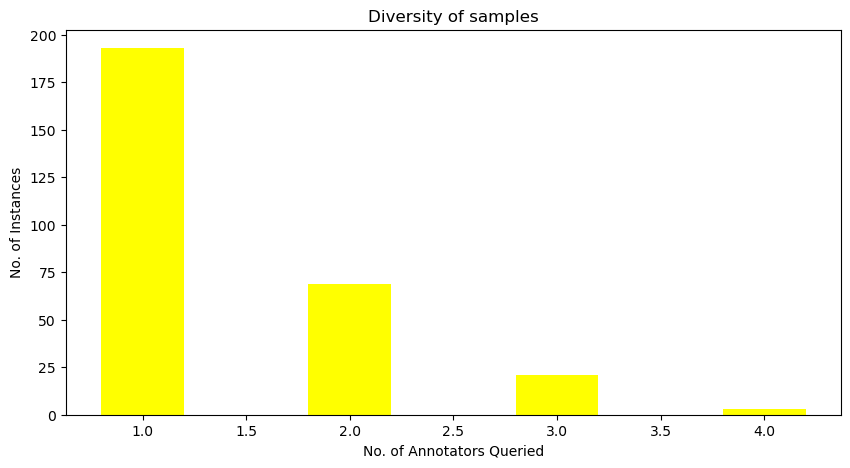

In [143]:
diverse_samples(inst_annot,full,None)

During BOOT we have all annotations -- train Annotator Model

Create Knowledge Base for each annotator. Instances providing Weights above threshold will be collected in the Knowledge base of that particular annotator.

SET SEEDS AT ALL PLACES SUCH AS TORCH, NUMPY ETC. RUN MULTIPLE TIMES AND CHECK
CLEAN CODE 
SET SEEDS AT ALL PLACES SUCH AS TORCH, NUMPY ETC. RUN MULTIPLE TIMES AND CHECK
SHARE RESULTS WITH ENTROPY BASED
ACCURACY OF TRAINING SET
DISPLAY DIVERSE SAMPLES
TRY EXPLORE EXPLOIT WITH DIFFERENT THRESHOLDS 
WEIGHTED INDEX FOR ANNOTATOR MODEL
CREATE NEW BRANCH AND PUSH FRESH CODE 